# Import All Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import talib
from pynance import portfolio_optimizer as po
import quantstats as qs

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14, 6)



# Load All Stock Files

In [2]:
import os

DATA_DIR = "../data/"     # Adjust path if needed

files = ["AAPL.csv", "AMZN.csv", "GOOG.csv", "META.csv", "MSFT.csv", "NVDA.csv"]

stocks = {}

for file in files:
    ticker = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(DATA_DIR, file))

    # Standard columns check
    df.columns = df.columns.str.lower()

    # Must-have columns
    needed_cols = ["open", "high", "low", "close", "volume"]
    if not all(col in df.columns for col in needed_cols):
        print(f"⚠ Warning: {ticker} missing required columns.")
    
    # Convert Date
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df.set_index("date", inplace=True)

    stocks[ticker] = df

stocks["AAPL"].head()


,close,high,low,open,volume
date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800


# Clean Data (Remove NaN, sort index, ensure numeric)

In [3]:
for ticker, df in stocks.items():
    df.sort_index(inplace=True)
    df.dropna(inplace=True)

    numeric = ["open", "high", "low", "close", "volume"]
    df[numeric] = df[numeric].apply(pd.to_numeric, errors="coerce")


# Apply TA-Lib Indicators to EACH STOCK

In [25]:
def add_indicators(df):

    price = df["close"]

    # Moving Averages
    df["SMA_20"] = talib.SMA(price, timeperiod=20)
    df["SMA_50"] = talib.SMA(price, timeperiod=50)
    df["EMA_20"] = talib.EMA(price, timeperiod=20)

    # RSI
    df["RSI_14"] = talib.RSI(price, timeperiod=14)

    # MACD
    macd, macd_signal, macd_hist = talib.MACD(price, fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD"] = macd
    df["MACD_signal"] = macd_signal
    df["MACD_hist"] = macd_hist

    # Bollinger Bands
    upper, middle, lower = talib.BBANDS(price, timeperiod=20)
    df["BB_upper"] = upper
    df["BB_middle"] = middle
    df["BB_lower"] = lower

    return df
for ticker, df in stocks.items():
    df["ticker"] = ticker
    stocks[ticker] = add_indicators(df)

print("Indicators added for:", list(stocks.keys()))
ticker = "AMZN"   # change to any: MSFT, META, AMZN, etc.
stocks[ticker].tail()


Indicators added for: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']


,close,high,low,open,volume,SMA_20,SMA_50,RSI_14,MACD,MACD_signal,MACD_hist,BB_upper,BB_middle,BB_lower,EMA_20,ticker
date,,,,,,,,,,,,,,,,
2023-12-22,153.419998,154.350006,152.710007,153.770004,29514100,148.578999,141.2430,64.115558,3.135958,2.873052,0.262905,154.696716,148.578999,142.461283,148.860492,AMZN
2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200,148.863000,141.7154,64.085644,3.118650,2.922172,0.196478,155.314929,148.863000,142.411071,149.293779,AMZN
2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700,149.178500,142.1312,63.860893,3.063965,2.950530,0.113434,155.854273,149.178500,142.502726,149.679133,AMZN
2023-12-28,153.380005,154.080002,152.949997,153.720001,27057000,149.531499,142.5694,63.938728,2.989395,2.958303,0.031092,156.311164,149.531499,142.751835,150.031597,AMZN
2023-12-29,151.940002,153.889999,151.029999,153.100006,39823200,149.824000,143.0456,59.012257,2.782032,2.923049,-0.141017,156.488309,149.824000,143.159691,150.213350,AMZN


# Plot Price + SMA + Bollinger Bands (for one stock)

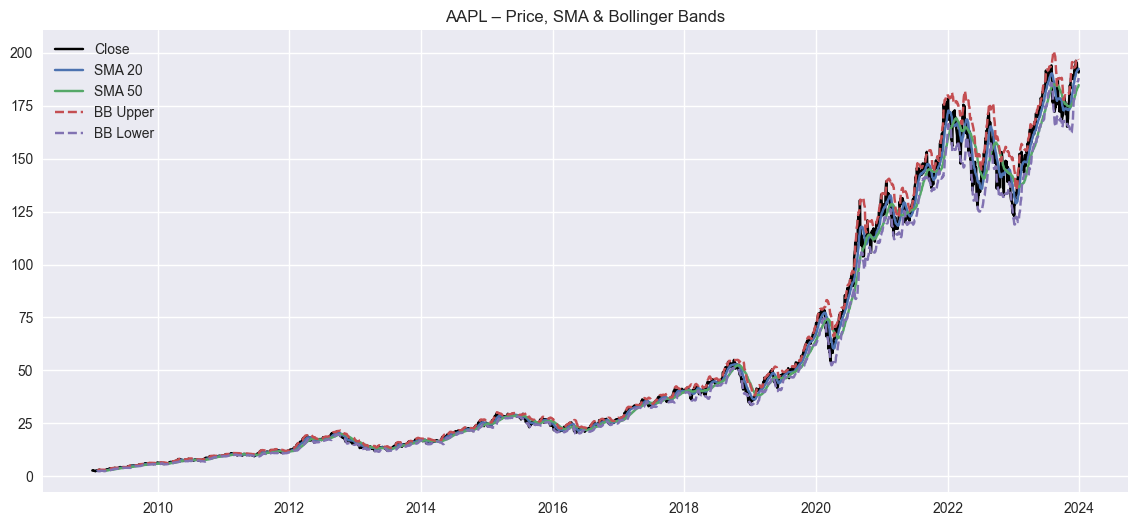

In [5]:
ticker = "AAPL"
df = stocks[ticker]

plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label="Close", color="black")
plt.plot(df.index, df["SMA_20"], label="SMA 20")
plt.plot(df.index, df["SMA_50"], label="SMA 50")
plt.plot(df.index, df["BB_upper"], label="BB Upper", linestyle="--")
plt.plot(df.index, df["BB_lower"], label="BB Lower", linestyle="--")

plt.title(f"{ticker} – Price, SMA & Bollinger Bands")
plt.legend()
plt.show()


# Plot RSI

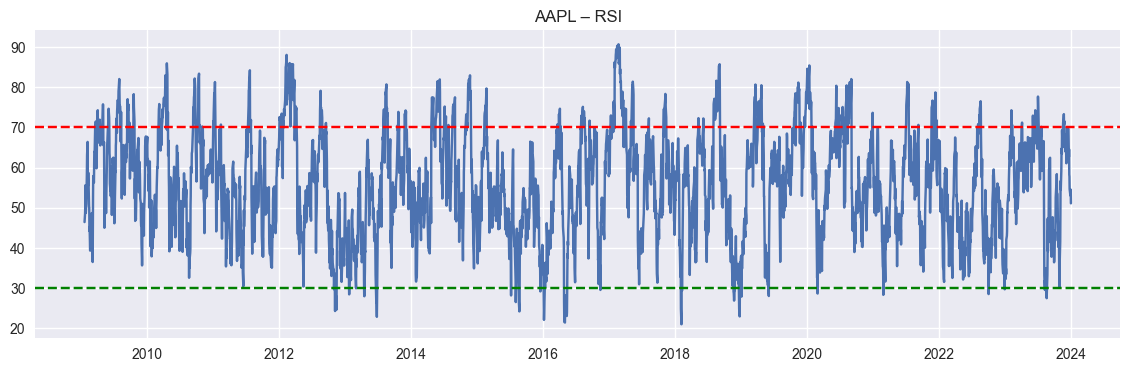

In [6]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["RSI_14"], label="RSI 14")
plt.axhline(70, color="red", linestyle="--")
plt.axhline(30, color="green", linestyle="--")
plt.title(f"{ticker} – RSI")
plt.show()


# Plot MACD

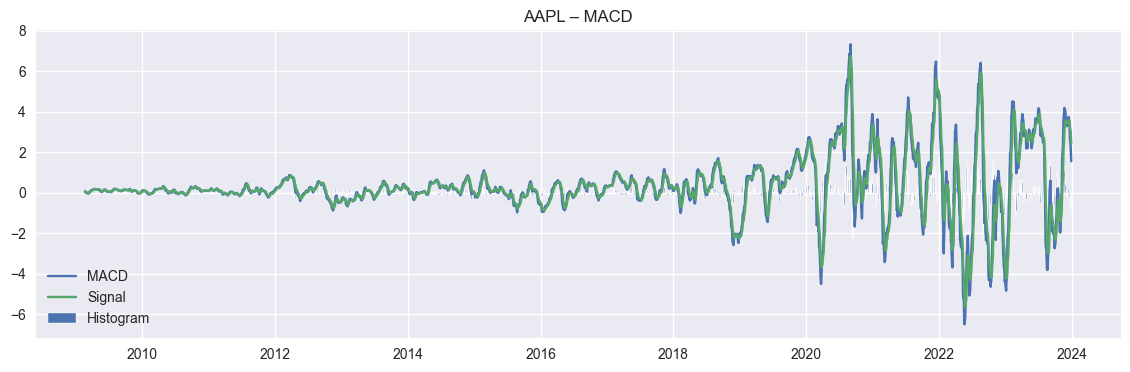

In [7]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["MACD_signal"], label="Signal")
plt.bar(df.index, df["MACD_hist"], label="Histogram")
plt.title(f"{ticker} – MACD")
plt.legend()
plt.show()


# PyNance Portfolio Analysis

In [8]:
TICKERS = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

portfolio = po.PortfolioCalculations(TICKERS)

print("=== Max Sharpe Ratio Portfolio ===")
print(portfolio.max_sharpe_portfolio("rr"))

print("=== Weights ===")
print(portfolio.max_sharpe_portfolio("df").head())

print("=== Minimum Variance Portfolio ===")
print(portfolio.min_var_portfolio("rr"))


d:\10acadamyWeek1Project\Predicting-Price-Moves-with-News-Sentiment\.venv\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
d:\10acadamyWeek1Project\Predicting-Price-Moves-with-News-Sentiment\.venv\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
d:\10acadamyWeek1Project\Predicting-Price-Moves-with-News-Sentiment\.venv\Lib\site-packages\pynance\datasources\data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated

=== Max Sharpe Ratio Portfolio ===
                   Max Sharpe Portfolio
Expected Return                  61.93%
Standard Deviation               34.85%
=== Weights ===
     Portfolio Weight
AAPL            0.00%
AMZN            0.00%
GOOG           49.53%
META            0.00%
MSFT            0.00%
=== Minimum Variance Portfolio ===
                   Min Var Portfolio
Expected Return               22.62%
Standard Deviation            19.96%


# Visualize Portfolio Returns (QuantStats)

In [10]:
import quantstats as qs

# combine close prices from your already loaded CSV files
close_prices = pd.DataFrame()

for ticker, df in stocks.items():
    close_prices[ticker] = df["close"]

# QuantStats expects returns, so calculate:
returns = close_prices.pct_change().dropna()

# Generate report (HTML file)
qs.reports.html(returns.mean(axis=1), output="portfolio_report.html")

print("Portfolio report saved as portfolio_report.html")


Portfolio report saved as portfolio_report.html


# Volume Trend Visualization

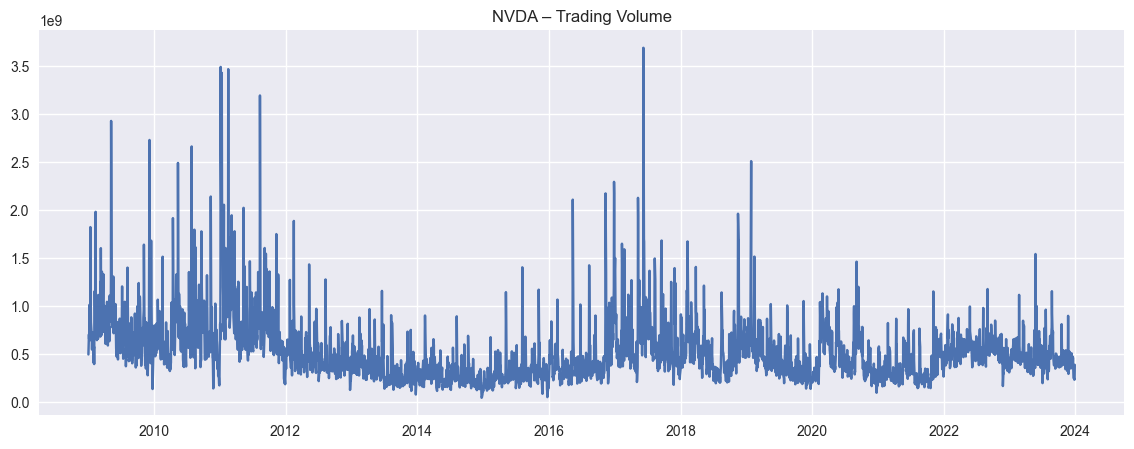

In [11]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df["volume"], label="Volume")
plt.title(f"{ticker} – Trading Volume")
plt.show()
